<a href="https://colab.research.google.com/github/ABD-01/Face-Unlock/blob/master/FaceNet_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import OrderedDict
import collections
from tqdm.notebook import tqdm
from PIL import Image
import PIL
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Subset
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_in :int , n_out :int , stride :int = 1, use_1x1conv=False):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)

        self.downsample = None
        if use_1x1conv:
            self.downsample = nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=stride, padding=0, bias=False)),
                ('bn', nn.BatchNorm2d(num_features=n_out))
            ]))

    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample:
            x_shortcut = self.downsample(x_shortcut)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# ref : https://d2l.ai/chapter_convolutional-modern/resnet.html
# ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L144


class ResNet(nn.Module):

    def __init__(self, num_classes=128, inplanes=3, layers = [2,2,2,2]):
        # resnet18 : layers = [2, 2, 2, 2]
        # resnet34 : layers = [3, 4, 6, 3]
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=inplanes, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 64, num_residuals = layers[0])                                 
        )
                            
        self.layer2 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 128, num_residuals = layers[1], reduce_dim = True) 
         )

        self.layer3 = nn.Sequential(
            self._make_layer(in_channels = 128, out_channels = 256, num_residuals = layers[2], reduce_dim = True) 
        )
                            
        self.layer4 = nn.Sequential(
            self._make_layer(in_channels = 256, out_channels = 512, num_residuals = layers[3], reduce_dim = True) 
        )
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=512*1, out_features=num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, in_channels:int, out_channels:int, num_residuals: int, reduce_dim = False):
        block_layers = []
        for i in range(num_residuals):
            if i == 0 and reduce_dim:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = in_channels, n_out = out_channels, stride=2, use_1x1conv = True)))
            else:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = out_channels, n_out = out_channels)))

        return OrderedDict( block_layers )
    
    # ref : https://d2l.ai/chapter_convolutional-modern/resnet.html

    def semi_forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x

    def forward(self,triplet):
        # anc = self.semi_forward(triplet[:,0,...])
        # pos = self.semi_forward(triplet[:,1,...])
        # neg = self.semi_forward(triplet[:,2,...])
        
        # triplet.shape = [m, 3, n_C, H, W]
        # batch_size = triplet.shape[0]
        # three = triplet.shape[1]
        # triplet = triplet.view(triplet.shape[0]*triplet.shape[1], *triplet.shape[2:])
        out = self.semi_forward(triplet)
        out = F.normalize(out, p=2, dim=1)
        # out = out.view(batch_size,3, *out.shape[1:])
        # anc_embeddings, pos_embeddings, neg_embeddings = torch.unbind(out, dim=1)
        return out

# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets
# ref: https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/5

In [ ]:
process = transforms.Compose([
    transforms.CenterCrop((114,114)),
    transforms.Resize((224,224), interpolation= transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize(mean=0.2, std=0.6),
])

In [ ]:
dataset = ImageFolder('/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled',
                      transform=process)
dataset

Dataset ImageFolder
    Number of datapoints: 13233
    Root location: /content/drive/MyDrive/lfw-dataset/lfw-deepfunneled
    StandardTransform
Transform: Compose(
               CenterCrop(size=(114, 114))
               Resize(size=(224, 224), interpolation=bicubic)
               ToTensor()
           )

In [ ]:
num_of_pixels = len(dataset) * 224 * 224
num_of_pixels

663979008

In [ ]:
loader = DataLoader(dataset, batch_size=100, num_workers=0)

In [ ]:
with torch.no_grad():
    total_sum = 0
    for batch in tqdm(loader): 
        total_sum += batch[0][0].sum()
    mean = total_sum / num_of_pixels

In [ ]:
sum_of_squared_error = 0
for batch in loader: 
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_of_pixels)

In [ ]:
datasets = train_val_dataset(dataset)

In [ ]:
len(datasets['train']), len(datasets['val'])

(10586, 2647)

In [ ]:
datasets['train'][5][0].shape

torch.Size([3, 112, 112])

In [ ]:
datasets['val'][5][1]

5531

In [ ]:
from glob import glob

In [ ]:
rand_path1 = random.choice(glob(random.choice(glob("/content/drive/MyDrive/lfw-dataset/lfw-cropped/*/"))+'*'))
rand_path2 = rand_path1.replace('cropped', 'deepfunneled').replace('.ppm', '.jpg')
print(rand_path1)
print(rand_path2)

/content/drive/MyDrive/lfw-dataset/lfw-cropped/Lidija_Djukanovic/Lidija_Djukanovic_0001.ppm
/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled/Lidija_Djukanovic/Lidija_Djukanovic_0001.jpg


In [ ]:
img = transforms.functional.to_tensor(
    transforms.functional.resize(
        transforms.functional.center_crop(
            Image.open(rand_path2)
            , (114,114)),
        (224,224), transforms.InterpolationMode.BICUBIC
        ))
img.shape

torch.Size([3, 224, 224])

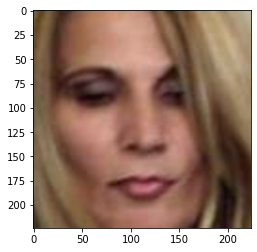

In [ ]:
plt.imshow(img.permute(1,2,0))

torch.Size([3, 64, 64]) torch.Size([3, 250, 250])


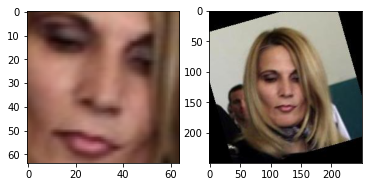

In [ ]:
img1 = transforms.functional.to_tensor(Image.open(rand_path1))
img2 = transforms.functional.to_tensor(Image.open(rand_path2))
print(img1.shape, img2.shape)
_, (axx1, axx2) = plt.subplots(1,2)
axx1.imshow(img1.permute(1,2,0))
axx2.imshow(img2.permute(1,2,0))

In [ ]:
RGB_MEAN = [ 0.485, 0.456, 0.406 ]
RGB_STD = [ 0.229, 0.224, 0.225 ]

In [ ]:
img = transforms.functional.normalize(
            transforms.functional.to_tensor(
                transforms.functional.resize(
                    Image.open("/content/drive/MyDrive/lfw-dataset/lfw-cropped/Chris_Tucker/Chris_Tucker_0001.ppm")
                    , size=(112,112))
                )
            , mean=RGB_MEAN, std=RGB_STD)


In [ ]:
img.mean(), img.std()

(tensor(-0.8732), tensor(0.4623))

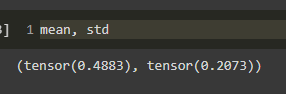

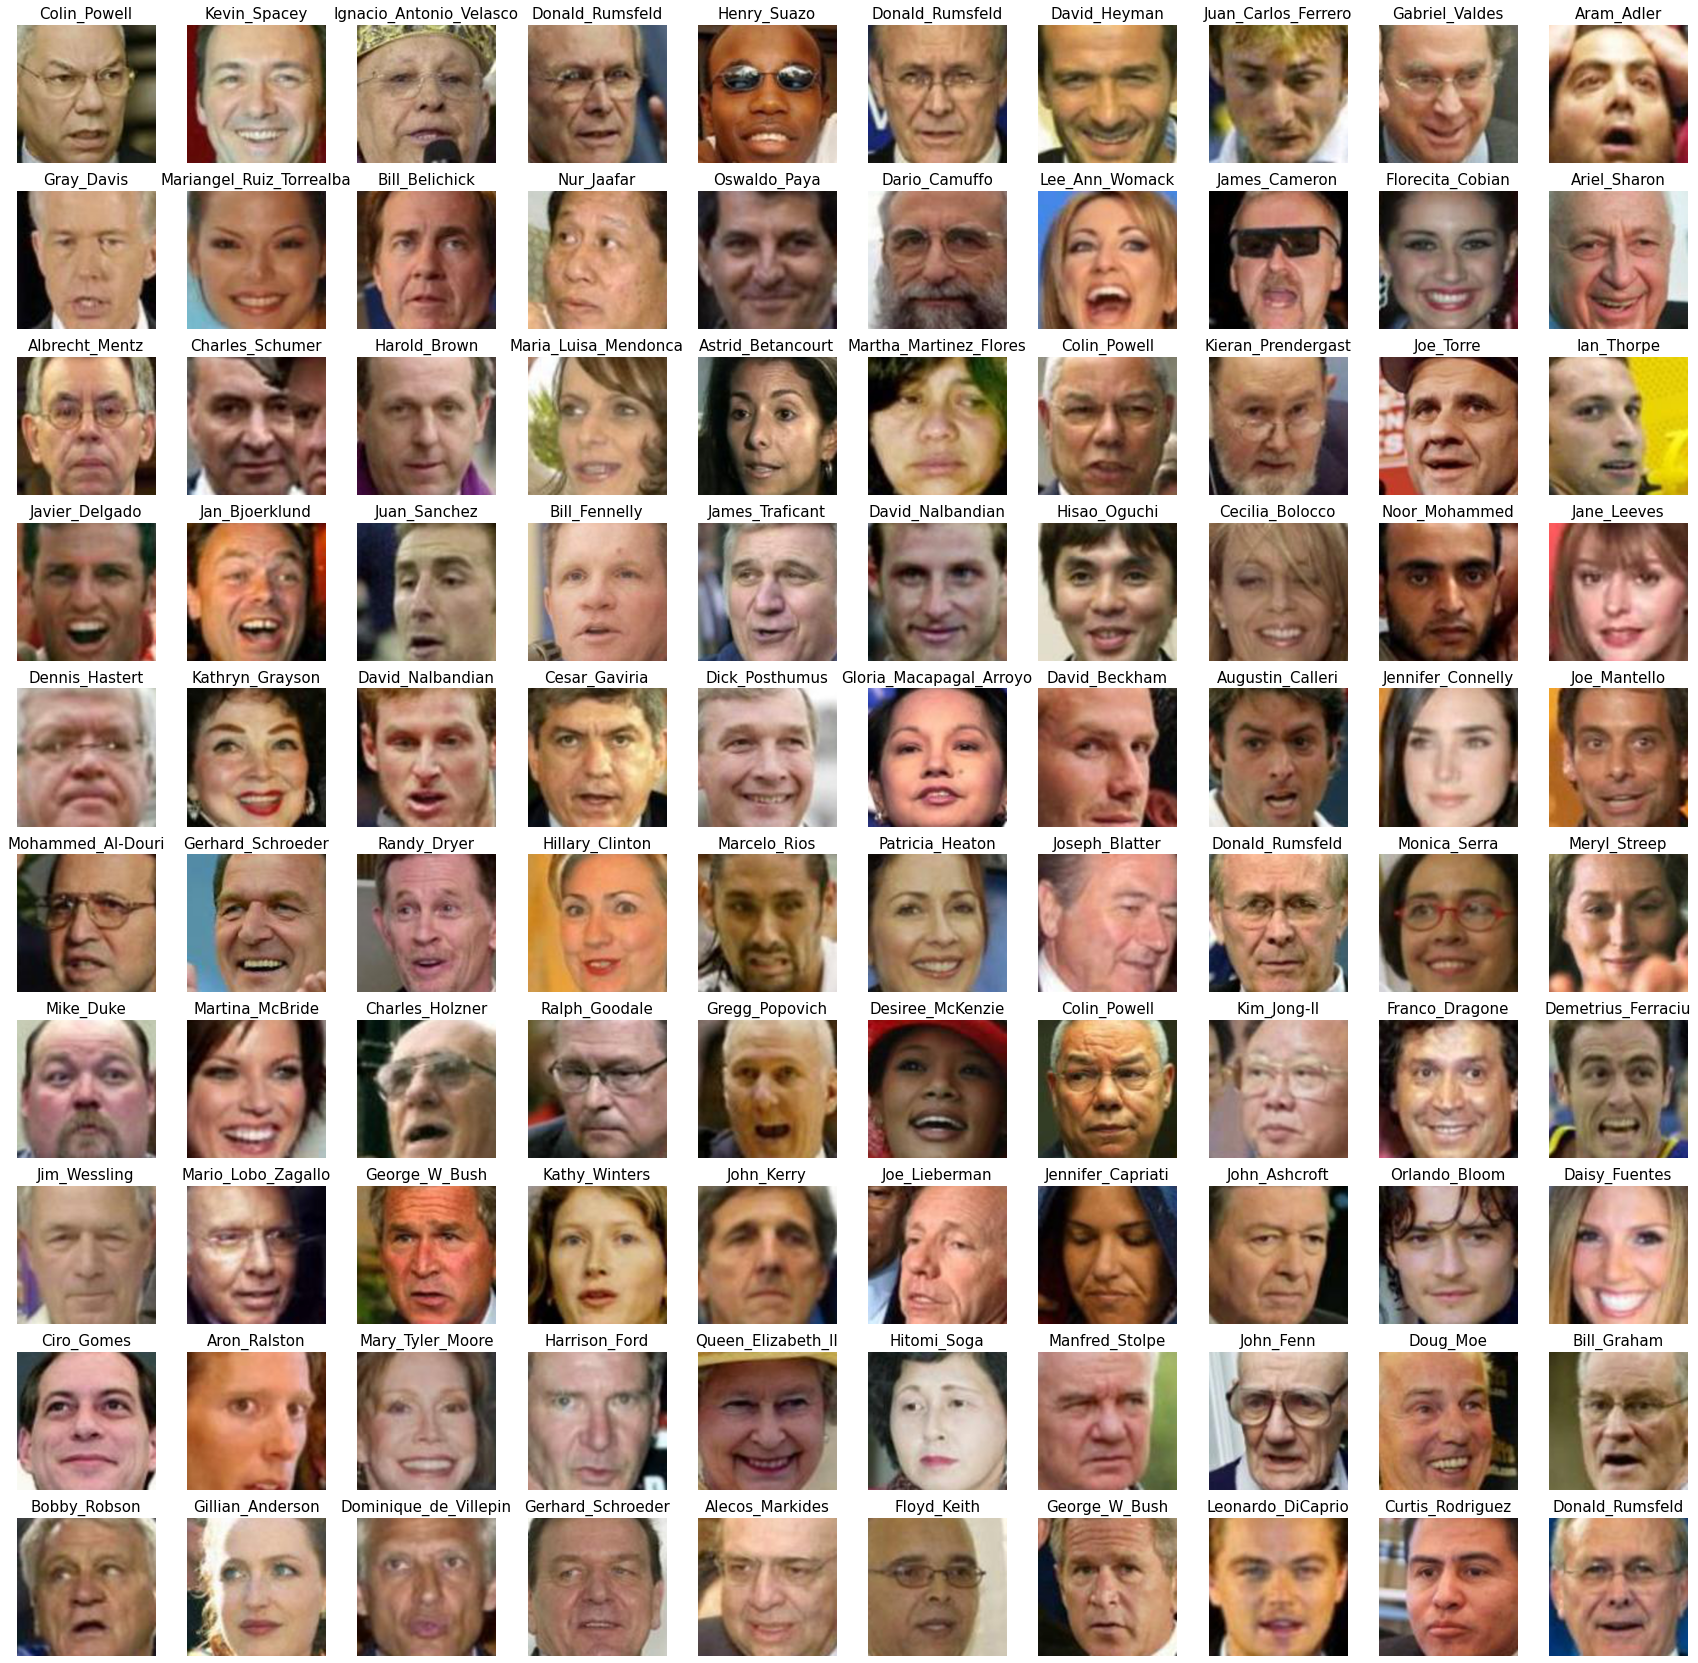

In [ ]:
_, axxr = plt.subplots(10,10, figsize=(30,30))
for ax in axxr.flatten():
    idx = random.randint(0, 10585)
    img = dataset[idx]
    ax.imshow(img[0].permute(1,2,0))
    ax.title.set_text(dataset.classes[img[1]])
    ax.title.set_size(15)
    ax.axis('off')
plt.show()

In [ ]:
resnet18 = ResNet()
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: abd1 (use `wandb login --relogin` to force relogin)


In [ ]:
import wandb
# 1. Start a new run
wandb.init(project="Face-Unlock", resume=True, id='2ftxlvtn')

In [ ]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.batch_size = 100
config.epochs = 100
config.learning_rate = "0.01, Reduce on Plateau"
config.fc_layer_size = 128
config.train_dataset = "LFW"
config.architechture = "ResNet18"

In [ ]:
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/triplet_loss.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/eval.py

--2021-05-27 15:14:20--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/triplet_loss.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8922 (8.7K) [text/plain]
Saving to: ‘triplet_loss.py’

triplet_loss.py     100%[===================>]   8.71K  --.-KB/s    in 0s      

2021-05-27 15:14:20 (70.2 MB/s) - ‘triplet_loss.py’ saved [8922/8922]

--2021-05-27 15:14:21--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2542 (2.5K) [text/plain]
Saving to: ‘ev

In [ ]:
import triplet_loss
from eval import calculate_metrics, evaluate

In [ ]:
batch_size = 100
dataloaders = {x:DataLoader(datasets[x], batch_size, shuffle=True, ) for x in ['train','val']}

In [ ]:
batch_size = 100
loader = DataLoader(dataset, batch_size=batch_size, num_workers=1, shuffle=True)

In [ ]:
optimizer18 = optim.Adam(resnet18.parameters(), lr = 0.001, amsgrad=True)

In [ ]:
scheduler18 = optim.lr_scheduler.ReduceLROnPlateau(optimizer18, factor=0.5, 
                                                   patience=100,
                                                   min_lr=0.00001,
                                                   verbose=True)

In [ ]:
wandb.watch(resnet18, criterion="tripletloss", log='all')

In [ ]:
resnet18.train()
epochs_loss =[]
epochs = 100
for epoch in range(21):
    try:
        epoch_loss = 0
        for step, (images, labels) in enumerate(loader):
            print(f"Epoch: {epoch:02d}, Step: {step:02d},", end=" ")
            start_time = time.time()

            embds = resnet18(images.to(device)).to('cpu')

            loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()

            optimizer18.zero_grad()
            loss.backward()
            optimizer18.step()
            scheduler18.step(loss)

            wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt,
                    "lr":optimizer18.state_dict()["param_groups"][0]['lr']})
            print(f"Loss: {loss.item():.3f}, +ve triplets: {fpt:.2f},", end=" ")

            current_time = time.time()
            print("Time: {:.4f}s".format(current_time-start_time))
        wandb.log({"epoch_loss": epoch_loss/config.batch_size})
        epochs_loss.append(epoch_loss/config.batch_size)
    except RuntimeError as re:
        device = torch.device('cpu')
        torch.save(resnet18.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/resnet18_lfw_checkpoint{epoch+2}.pth")
        resnet18.cpu()
        print(f"{re}: Shifted to CPU")

Epoch: 00, Step: 00, Loss: 0.565, +ve triplets: 0.34, Time: 0.2062s
Epoch: 00, Step: 01, Loss: 0.839, +ve triplets: 0.34, Time: 0.1408s
Epoch: 00, Step: 02, Loss: 0.961, +ve triplets: 0.25, Time: 0.1446s
Epoch: 00, Step: 03, Loss: 0.854, +ve triplets: 0.33, Time: 0.1425s
Epoch: 00, Step: 04, Loss: 0.996, +ve triplets: 0.56, Time: 0.1433s
Epoch: 00, Step: 05, Loss: 0.571, +ve triplets: 0.60, Time: 0.1410s
Epoch: 00, Step: 06, Loss: 0.709, +ve triplets: 0.45, Time: 0.1420s
Epoch: 00, Step: 07, Loss: 0.834, +ve triplets: 0.31, Time: 0.1423s
Epoch: 00, Step: 08, Loss: 0.903, +ve triplets: 0.44, Time: 0.1472s
Epoch: 00, Step: 09, Loss: 0.794, +ve triplets: 0.49, Time: 0.1454s
Epoch: 00, Step: 10, Loss: 0.859, +ve triplets: 0.32, Time: 0.1446s
Epoch: 00, Step: 11, Loss: 0.838, +ve triplets: 0.78, Time: 0.1433s
Epoch: 00, Step: 12, Loss: 0.567, +ve triplets: 0.42, Time: 0.1436s
Epoch: 00, Step: 13, Loss: 0.818, +ve triplets: 0.44, Time: 0.1418s
Epoch: 00, Step: 14, Loss: 0.743, +ve triplets: 

In [ ]:
torch.save(resnet18.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/resnet18_lfw_1.pth")

In [ ]:
resnet18 = ResNet()
resnet18.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/resnet18_lfw_checkpoint37.pth"))

<All keys matched successfully>

In [ ]:
resnet18.cuda()

In [ ]:
def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs)

def get_paths(lfw_dir, pairs, file_ext='jpg'):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])+'.'+file_ext)
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])+'.'+file_ext)
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list



In [ ]:
class LFWDataset(data.Dataset):
    '''
        Dataset subclass for loading LFW images in PyTorch.
        This returns multiple images in a batch.
    '''

    def __init__(self, path_list, issame_list, transforms, split = 'test'):
        '''
            Parameters
            ----------
            path_list    -   List of full path-names to LFW images
        ''' 
        self.files = collections.defaultdict(list)
        self.split = split
        self.files[split] =  path_list
        self.pair_label = issame_list
        self.transforms = transforms

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_file = self.files[self.split][index]
        img = PIL.Image.open(img_file)

        im_out = self.transforms(img)
        return im_out


In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt

--2021-05-27 19:17:31--  http://vis-www.cs.umass.edu/lfw/pairs.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155335 (152K) [text/plain]
Saving to: ‘pairs.txt’

pairs.txt           100%[===================>] 151.69K   633KB/s    in 0.2s    

2021-05-27 19:17:32 (633 KB/s) - ‘pairs.txt’ saved [155335/155335]



In [ ]:
pairs = read_pairs("/content/pairs.txt")
print(pairs)

path_list, issame_list = get_paths("/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled",
                                         pairs, 
                                         "jpg")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


[list(['Abel_Pacheco', '1', '4']) list(['Akhmed_Zakayev', '1', '3'])
 list(['Akhmed_Zakayev', '2', '3']) ...
 list(['Shane_Loux', '1', 'Val_Ackerman', '1'])
 list(['Shawn_Marion', '1', 'Shirley_Jones', '1'])
 list(['Slobodan_Milosevic', '2', 'Sok_An', '1'])]


In [ ]:
# Create data loader
test_loader = torch.utils.data.DataLoader(
                    LFWDataset(
                    path_list, issame_list, transforms=process), 
                    batch_size=64, shuffle=False, num_workers=1)


In [ ]:
len(test_loader)

188

In [ ]:
resnet18.eval()

In [ ]:
features = []
for idx, batch in tqdm(enumerate(test_loader), desc="Creating Embeddings"):
    try:
        feat = resnet18(batch.to(device)).cpu()
        features.append(feat.detach().numpy())
    except RuntimeError as re:
        device = torch.device('cpu')
        resnet18.cpu()
        print(f"{re}: Shifted to CPU")

In [ ]:
def dist_(enc1,enc2):
    return (enc1 - enc2).__pow__(2).sum(-1).__pow__(.5)

In [ ]:
features = np.concatenate(features)
features.shape

(12000, 128)

In [ ]:
num_feat = 12000
pair1 = features[np.arange(0,num_feat,2),:]
pair2 = features[np.arange(1,num_feat,2),:]

In [ ]:
distances = dist_(pair1, pair2)

In [ ]:
psame = np.asarray(issame_list)

In [ ]:
distances.shape, psame.shape

((6000,), (6000,))

In [ ]:
def calculate_metrics(threshold, dist, psame):
    pdiff = np.logical_not(psame)
    preds = np.less(dist, threshold)
    
    true_accepts  = np.sum(np.logical_and(preds, psame))
    false_accepts = np.sum(np.logical_and(preds, pdiff))
    # false_rejects = np.sum(np.logical_and(np.logical_not(preds), psame))
    true_rejects  = np.sum(np.logical_and(np.logical_not(preds), pdiff))

    val = true_accepts  / (psame.sum() + 1e-16) # sensitivity, recall
    far = false_accepts / (pdiff.sum() + 1e-16) # (1-specificity)
    # frr = false_rejects / (psame.sum() + 1e-16)
    # frr = 1 - val
    # trr = true_rejects  / (pdiff.sum() + 1e-16) # specificity 
    # trr = 1 - far

    precision = true_accepts / (true_accepts + false_accepts + 1e-16)
    # a ratio of correctly predicted positive observations to the total predicted positive observations
    accuracy = (true_accepts + true_rejects) / (psame.sum() + pdiff.sum() + 1e-16)
    # a ratio of correctly predicted observation to the total observations

    return val, far, precision, accuracy

In [ ]:
val, far, precision, accuracy = calculate_metrics(0.78, distances, psame)

print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 0.6266666666666667
False Accept Rate = 0.28
Precision = 0.6911764705882353
Accuracy = 0.6733333333333333


In [ ]:
def evaluate(distances, labels, roc_curve=False):
    # mask = np.logical_not(np.eye(labels.shape[0], dtype='bool'))
    # Psame = labels[mask]
    # distances = distances[mask]
    thresholds = np.arange(0,4,0.01)
    num_thresholds = len(thresholds)
    vals = np.zeros(num_thresholds)
    fars = np.zeros(num_thresholds)
    youdens = np.zeros(num_thresholds)
    for idx, threshold in tqdm(enumerate(thresholds)):
        vals[idx], fars[idx], _, _ = calculate_metrics(threshold, distances, labels)
        youdens[idx] = vals[idx] - fars[idx] # sensitivity + specificity — 1
    best_threshold_idx = np.argmax(youdens) 

    if roc_curve:
        fig = plt.figure()
        plt.plot(fars, vals, marker = '.', c='r')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.scatter(fars[best_threshold_idx], vals[best_threshold_idx], c='black', label='Optimal Threshold')
        plt.grid()
        plt.title('ROC Curve')
        plt.xlabel('False Accept Rate (FAR)')
        plt.ylabel('True Accept Rate (VAL)')
        plt.legend()
        plt.savefig('ROC_curve')
        plt.show()


    true_accept_rate, false_accept_rate, precision, accuracy = \
         calculate_metrics(thresholds[best_threshold_idx], distances, labels)

    return thresholds[best_threshold_idx], true_accept_rate, false_accept_rate, precision, accuracy

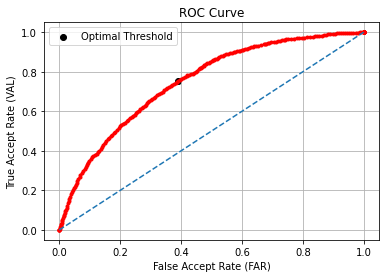

In [ ]:
best_threshold, tar, far, precision, accuracy  = evaluate(distances, psame, True)

In [ ]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 1.0
True Acceptance: 0.754
False Acceptance: 0.390
Precision: 0.659
Accuracy: 0.682


In [ ]:
test_dataset = LFWDataset(path_list, issame_list, transforms=process)

# Validating

In [ ]:
preds = distances<1.0

In [ ]:
pdiff = np.logical_not(psame)

true_accepts  = np.sum(np.logical_and(preds, psame))
false_accepts = np.sum(np.logical_and(preds, pdiff))
# false_rejects = np.sum(np.logical_and(np.logical_not(preds), psame))
true_rejects  = np.sum(np.logical_and(np.logical_not(preds), pdiff))

true_accepts, false_accepts, true_rejects

(2263, 1171, 1829)

In [ ]:
psame.sum(), pdiff.sum()

(3000, 3000)

In [ ]:
val = true_accepts  / (psame.sum() + 1e-16) # sensitivity, recall
far = false_accepts / (pdiff.sum() + 1e-16) # (1-specificity)

val, far

(0.7543333333333333, 0.3903333333333333)

In [ ]:
false_accepts = np.logical_and(preds, pdiff)

In [ ]:
false_accepts.sum()

1171

In [ ]:
false_accept_idxs =  (false_accepts == 1).nonzero()[0]
false_accept_idxs

array([ 301,  304,  305, ..., 5990, 5991, 5995])

410


<Figure size 432x288 with 0 Axes>

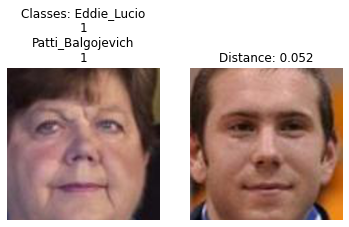

600


<Figure size 432x288 with 0 Axes>

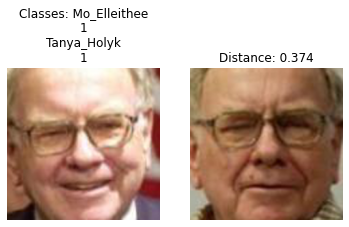

563


<Figure size 432x288 with 0 Axes>

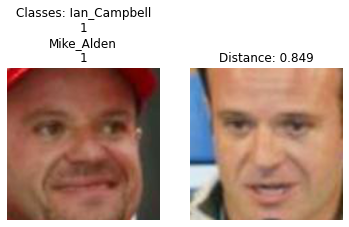

155


<Figure size 432x288 with 0 Axes>

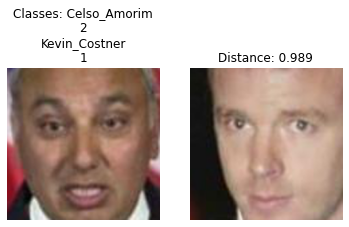

202


<Figure size 432x288 with 0 Axes>

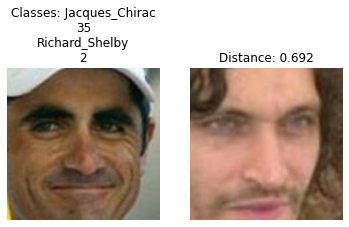

583


<Figure size 432x288 with 0 Axes>

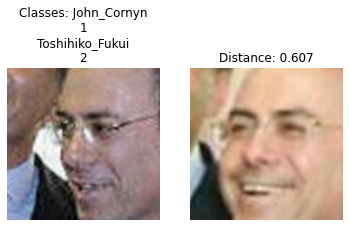

793


<Figure size 432x288 with 0 Axes>

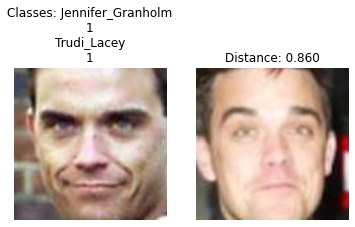

219


<Figure size 432x288 with 0 Axes>

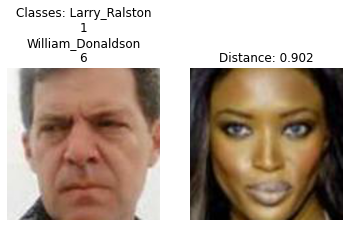

427


<Figure size 432x288 with 0 Axes>

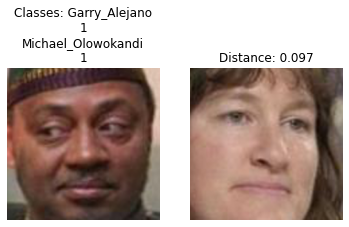

718


<Figure size 432x288 with 0 Axes>

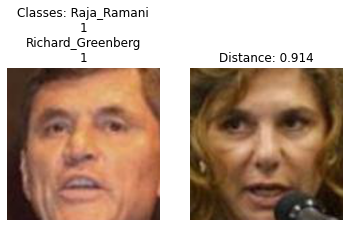

598


<Figure size 432x288 with 0 Axes>

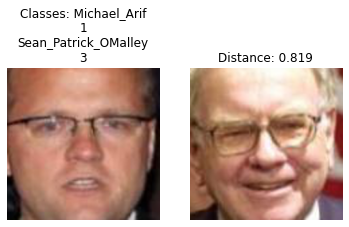

915


<Figure size 432x288 with 0 Axes>

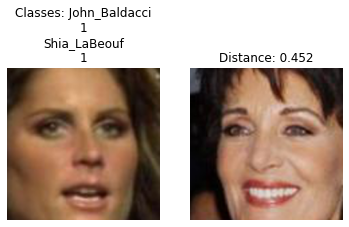

292


<Figure size 432x288 with 0 Axes>

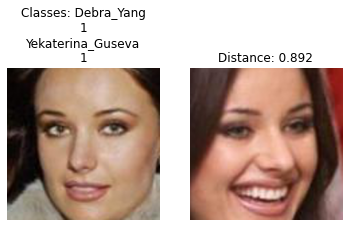

859


<Figure size 432x288 with 0 Axes>

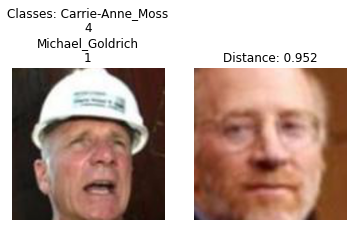

1056


<Figure size 432x288 with 0 Axes>

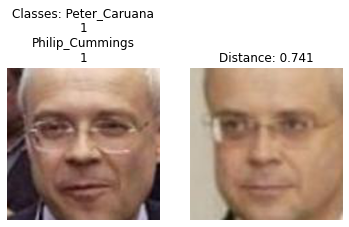

484


<Figure size 432x288 with 0 Axes>

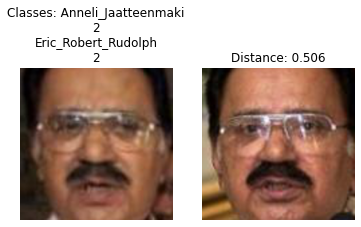

528


<Figure size 432x288 with 0 Axes>

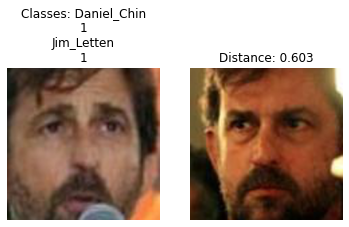

256


<Figure size 432x288 with 0 Axes>

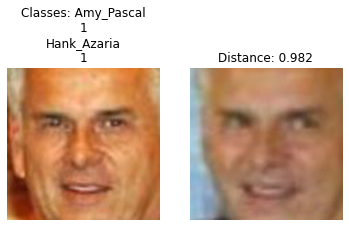

713


<Figure size 432x288 with 0 Axes>

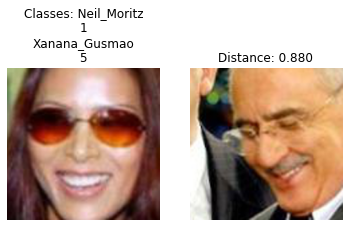

167


<Figure size 432x288 with 0 Axes>

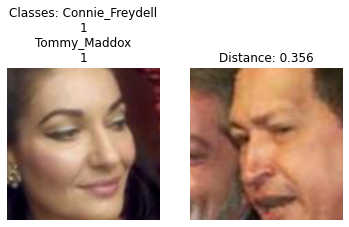

26


<Figure size 432x288 with 0 Axes>

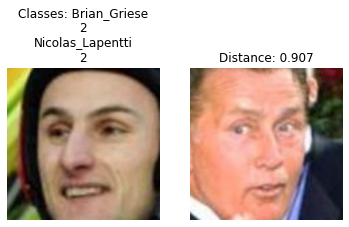

788


<Figure size 432x288 with 0 Axes>

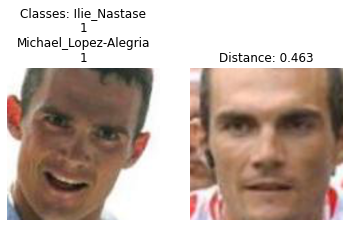

31


<Figure size 432x288 with 0 Axes>

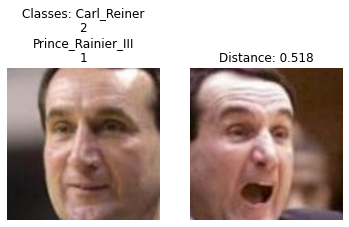

623


<Figure size 432x288 with 0 Axes>

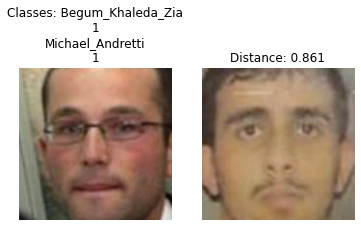

665


<Figure size 432x288 with 0 Axes>

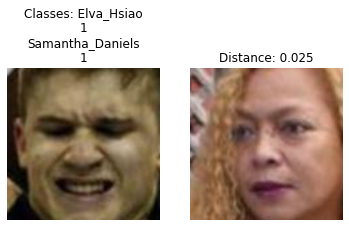

90


<Figure size 432x288 with 0 Axes>

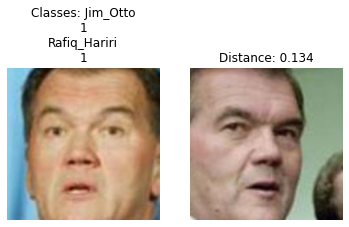

1164


<Figure size 432x288 with 0 Axes>

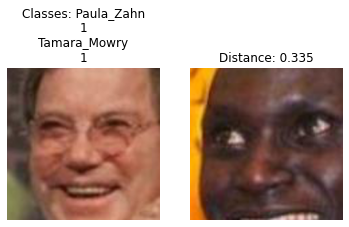

1067


<Figure size 432x288 with 0 Axes>

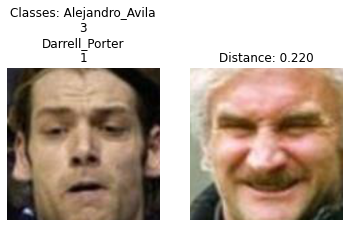

619


<Figure size 432x288 with 0 Axes>

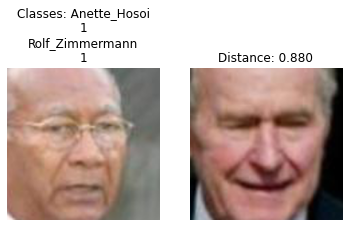

70


<Figure size 432x288 with 0 Axes>

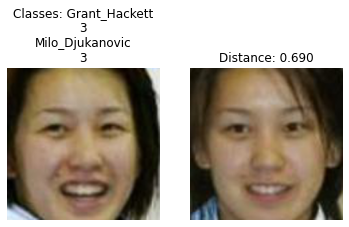

In [ ]:
for idx in np.random.randint(0,1171, size=30):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1= false_accept_idxs[idx]
    idx2 = idx1+1

    i1.imshow(test_dataset[idx1].permute(1,2,0))
    i2.imshow(test_dataset[idx2].permute(1,2,0))
    # i1.title.set_text(f'Classes: {path_list[idx1].split("/")[-2]}\n{path_list[idx2].split("/")[-2]}')
    i1.title.set_text('Classes: {}'.format("\n".join(pairs[idx1])))
    i2.title.set_text(f'Distance: {distances[idx1]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()

In [ ]:
false_accept_idxs[70]

482

In [ ]:
pairs[482]

['Grant_Hackett', '3', 'Milo_Djukanovic', '3']

In [ ]:
path_list[482].split('/')[-2]

'Sachiko_Yamada'

In [ ]:
path_list[482]

'/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled/Sachiko_Yamada/Sachiko_Yamada_0002.jpg'

In [ ]:
path_list[482]

'/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled/Sachiko_Yamada/Sachiko_Yamada_0002.jpg'

In [ ]:
psame[482]

False

In [ ]:
!wget https://raw.githubusercontent.com/tamerthamoqa/facenet-pytorch-glint360k/63a18012427311e7df0773e045ada88b32fb854c/validate_on_LFW.py

--2021-05-27 19:21:49--  https://raw.githubusercontent.com/tamerthamoqa/facenet-pytorch-glint360k/63a18012427311e7df0773e045ada88b32fb854c/validate_on_LFW.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8721 (8.5K) [text/plain]
Saving to: ‘validate_on_LFW.py’

validate_on_LFW.py  100%[===================>]   8.52K  --.-KB/s    in 0s      

2021-05-27 19:21:50 (86.5 MB/s) - ‘validate_on_LFW.py’ saved [8721/8721]



In [ ]:
from validate_on_LFW import evaluate_lfw

In [ ]:
true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=distances,
            labels=psame,
            far_target=1e-3
        )
# Print statistics and add to log
print("Accuracy on LFW: {:.4f}+-{:.4f}\nPrecision {:.4f}+-{:.4f}\nRecall {:.4f}+-{:.4f}\n"
        "ROC Area Under Curve: {:.4f}\nBest distance threshold: {:.2f}+-{:.2f}\n"
        "TAR: {:.4f}+-{:.4f} @ FAR: {:.4f}".format(
            np.mean(accuracy),
            np.std(accuracy),
            np.mean(precision),
            np.std(precision),
            np.mean(recall),
            np.std(recall),
            roc_auc,
            np.mean(best_distances),
            np.std(best_distances),
            np.mean(tar),
            np.std(tar),
            np.mean(far)
        ))

Accuracy on LFW: 0.6797+-0.0242
Precision 0.6581+-0.0204
Recall 0.7480+-0.0319
ROC Area Under Curve: 0.7501
Best distance threshold: 0.99+-0.02
TAR: 0.0060+-0.0047 @ FAR: 0.0013


# Sweep

In [ ]:
import wandb

In [ ]:
sweep_config = {
    'method': 'random' # grid, random, bayes
    }

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

In [ ]:
parameter_dict = {
    'fc_layer_size': {
        'values': [64, 128, 256]
    },
    'learning_rate': {
        'values': [0.001, 0.002,  0.0002, 0.0001]
    },
    'batch_size': {
        'values': [100, 200, 500]
    },
    'epochs': {
        'values': [10,50,100]
    }
}
sweep_config['parameters'] = parameter_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [100, 200, 500]},
                'epochs': {'values': [10, 50, 100]},
                'fc_layer_size': {'values': [64, 128, 256]},
                'learning_rate': {'values': [0.001, 0.002, 0.0002, 0.0001]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project='Face-Unlock')

Create sweep with ID: q77dzonw
Sweep URL: https://wandb.ai/abd1/Face-Unlock/sweeps/q77dzonw


In [ ]:
def pairs_mask(labels):
    induces_not_equal = torch.eye(labels.shape[0]).bool().logical_not()
    return induces_not_equal

In [ ]:
import torch.optim as optim

In [ ]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'batch_size': 100,
        'epochs': 20,
        'fc_layer_size': 128,
        'learning_rate': 0.001,
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # define model
    network = ResNet(num_classes=config.fc_layer_size)
    # train loader 
    loader = DataLoader(datasets['train'], config.batch_size, shuffle=True, num_workers=1)
    # optimizer
    optimizer = optim.Adam(network.parameters(), lr=config.learning_rate)

    network.train()
    for epoch in range(config.epochs):
        epoch_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            embds = network(images)
            loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()
            wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt}, commit=False)
            loss.backward()
            optimizer.step()

        wandb.log({"epoch_loss": epoch_loss / config.batch_size})

In [ ]:
wandb.agent(sweep_id, train, count=10)

wandb: Agent Starting Run: b4gy35es with config:
wandb: 	batch_size: 500
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.002


Run b4gy35es errored: RuntimeError('Given input size: (512x4x4). Calculated output size: (512x0x0). Output size is too small')
wandb: ERROR Run b4gy35es errored: RuntimeError('Given input size: (512x4x4). Calculated output size: (512x0x0). Output size is too small')
wandb: Agent Starting Run: szt2ht7g with config:
wandb: 	batch_size: 100
wandb: 	epochs: 50
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.001


Run szt2ht7g errored: RuntimeError('Given input size: (512x4x4). Calculated output size: (512x0x0). Output size is too small')
wandb: ERROR Run szt2ht7g errored: RuntimeError('Given input size: (512x4x4). Calculated output size: (512x0x0). Output size is too small')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pol5m0w9 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 50
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0001


Run pol5m0w9 errored: RuntimeError('Given input size: (512x4x4). Calculated output size: (512x0x0). Output size is too small')
wandb: ERROR Run pol5m0w9 errored: RuntimeError('Given input size: (512x4x4). Calculated output size: (512x0x0). Output size is too small')
wandb: Agent Starting Run: kqvs3v0l with config:
wandb: 	batch_size: 500
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.0001


In [ ]:
wandb.finish()

# Evalute lfw
ref:
* [eval_lfw.py](https://github.com/AruniRC/resnet-face-pytorch/blob/master/lfw/eval_lfw.py#L93)
* [utils.py](https://github.com/AruniRC/resnet-face-pytorch/blob/master/utils.py#L264)

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt

--2021-05-26 14:48:13--  http://vis-www.cs.umass.edu/lfw/pairs.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155335 (152K) [text/plain]
Saving to: ‘pairs.txt.1’

pairs.txt.1         100%[===================>] 151.69K   261KB/s    in 0.6s    

2021-05-26 14:48:14 (261 KB/s) - ‘pairs.txt.1’ saved [155335/155335]



In [ ]:
def get_paths(lfw_dir, pairs, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in tqdm(pairs):
        if len(pair) == 3:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])+'.'+file_ext)
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])+'.'+file_ext)
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list


def read_pairs(pairs_filename, lfw_flag=True):
    pairs = []
    with open(pairs_filename, 'r') as f:
        if lfw_flag:
            for line in f.readlines()[1:]:
                pair = line.strip().split()
                pairs.append(pair)
        else:
            for line in f.readlines():
                pair = line.strip().split()
                pairs.append(pair)      
    return np.array(pairs)

In [ ]:
pairs = read_pairs("/content/pairs.txt")
print(pairs)

path_list, issame_list = get_paths("/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled",
                                         pairs, 
                                         "jpg")

[list(['Abel_Pacheco', '1', '4']) list(['Akhmed_Zakayev', '1', '3'])
 list(['Akhmed_Zakayev', '2', '3']) ...
 list(['Shane_Loux', '1', 'Val_Ackerman', '1'])
 list(['Shawn_Marion', '1', 'Shirley_Jones', '1'])
 list(['Slobodan_Milosevic', '2', 'Sok_An', '1'])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
len(pairs)

6000

In [ ]:
print(len(path_list), len(issame_list))

12000 6000


In [ ]:
DEBUG = False

class LFWDataset(data.Dataset):
    '''
        Dataset subclass for loading LFW images in PyTorch.
        This returns multiple images in a batch.
    '''

    def __init__(self, path_list, issame_list, transforms, split = 'test'):
        '''
            Parameters
            ----------
            path_list    -   List of full path-names to LFW images
        ''' 
        self.files = collections.defaultdict(list)
        self.split = split
        self.files[split] =  path_list
        self.pair_label = issame_list
        self.transforms = transforms

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_file = self.files[self.split][index]
        img = PIL.Image.open(img_file)
        if DEBUG:
            print(img_file)
        im_out = self.transforms(img)
        return im_out

In [ ]:
img = Image.open('/content/drive/MyDrive/lfw-dataset/lfw-deepfunneled/Ahmed_Lopez/Ahmed_Lopez_0001.jpg')
img.size

(250, 250)

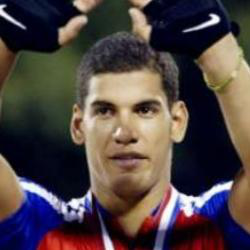

In [ ]:
img

In [ ]:
# Define data transforms
RGB_MEAN = [ 0.485, 0.456, 0.406 ]
RGB_STD = [ 0.229, 0.224, 0.225 ]
test_transform = transforms.Compose([
    transforms.Scale((250,250)),  # make 250x250
    transforms.CenterCrop(150),   # then take 150x150 center crop
    transforms.Scale((224,224)),  # resized to the network's required input size
    transforms.ToTensor(),
    transforms.Normalize(mean = RGB_MEAN,
                            std = RGB_STD),
    transforms.Grayscale(),
])

# Create data loader
test_loader = torch.utils.data.DataLoader(
                    LFWDataset(
                    path_list, issame_list, test_transform), 
                    batch_size=32, shuffle=False, num_workers=2)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
path = "/content/drive/MyDrive/ABD Colab Notebooks/facenet(64)6_checkpoint2.pth"
resnet18 = ResNet(num_classes=64, inplanes=1)
resnet18.to("cuda")
resnet18.load_state_dict(torch.load(path))
resnet18.eval()


In [ ]:
import PIL

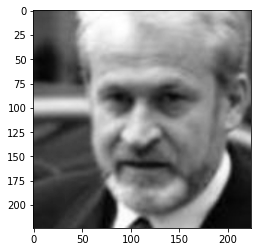

In [ ]:
sample =next(iter(test_loader))
plt.imshow(sample[4].squeeze(), cmap='gray')

In [ ]:
device

device(type='cuda')

In [ ]:
distances = []
features = []
for idx, batch in tqdm(enumerate(test_loader), desc="Creating Embeddings"):
    try:
        feat = resnet18(batch.to(device)).cpu()
        num_feat = feat.size()[0]
        pair1 = feat[np.arange(0,num_feat,2),:]
        pair2 = feat[np.arange(1,num_feat,2),:]
        distances.append((pair1-pair2).norm(p=2,dim=1))
    except RuntimeError:
        device = torch.device('cpu')

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
resnet18.cuda()

In [ ]:
resnet18.conv1.weight.device, device

(device(type='cuda', index=0), device(type='cuda'))

In [ ]:
features = []
for idx, batch in tqdm(enumerate(test_loader), desc="Creating Embeddings"):
    try:
        feat = resnet18(batch.to(device)).cpu()
        features.append(feat.detach().numpy())
    except RuntimeError as re:
        device = torch.device('cpu')
        resnet18.cpu()
        print(f"{re}: Shifted to CPU")

In [ ]:
features.__len__()

375

In [ ]:
feats = np.concatenate(features, axis=0)
feats.shape

(12000, 64)

In [ ]:
np.save("LFW_features.npy", feats)

In [ ]:
num_feat = 12000
pair1 = feats[np.arange(0,num_feat,2),:]
pair2 = feats[np.arange(1,num_feat,2),:]

In [ ]:
def dist_(enc1,enc2):
    return (enc1 - enc2).__pow__(2).sum(-1).__pow__(.5)

In [ ]:
distances = dist_(pair1, pair2)

In [ ]:
psame = np.asarray(issame_list)

In [ ]:
distances.shape, psame.shape

((6000,), (6000,))

In [ ]:
def calculate_metrics(threshold, dist, psame):
    pdiff = np.logical_not(psame)
    preds = np.less(dist, threshold)
    
    true_accepts  = np.sum(np.logical_and(preds, psame))
    false_accepts = np.sum(np.logical_and(preds, pdiff))
    # false_rejects = np.sum(np.logical_and(np.logical_not(preds), psame))
    true_rejects  = np.sum(np.logical_and(np.logical_not(preds), pdiff))

    val = true_accepts  / (psame.sum() + 1e-16) # sensitivity, recall
    far = false_accepts / (pdiff.sum() + 1e-16) # (1-specificity)
    # frr = false_rejects / (psame.sum() + 1e-16)
    # frr = 1 - val
    # trr = true_rejects  / (pdiff.sum() + 1e-16) # specificity 
    # trr = 1 - far

    precision = true_accepts / (true_accepts + false_accepts + 1e-16)
    # a ratio of correctly predicted positive observations to the total predicted positive observations
    accuracy = (true_accepts + true_rejects) / (psame.sum() + pdiff.sum() + 1e-16)
    # a ratio of correctly predicted observation to the total observations

    return val, far, precision, accuracy

In [ ]:
val, far, precision, accuracy = calculate_metrics(0.78, distances, psame)

print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 0.7186666666666667
False Accept Rate = 0.521
Precision = 0.5797257327238505
Accuracy = 0.5988333333333333


In [ ]:
def evaluate(distances, labels, roc_curve=False):
    # mask = np.logical_not(np.eye(labels.shape[0], dtype='bool'))
    # Psame = labels[mask]
    # distances = distances[mask]
    thresholds = np.arange(0,4,0.01)
    num_thresholds = len(thresholds)
    vals = np.zeros(num_thresholds)
    fars = np.zeros(num_thresholds)
    youdens = np.zeros(num_thresholds)
    for idx, threshold in tqdm(enumerate(thresholds)):
        vals[idx], fars[idx], _, _ = calculate_metrics(threshold, distances, labels)
        youdens[idx] = vals[idx] - fars[idx] # sensitivity + specificity — 1
    best_threshold_idx = np.argmax(youdens) 

    if roc_curve:
        fig = plt.figure()
        plt.plot(fars, vals, marker = '.', c='r')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.scatter(fars[best_threshold_idx], vals[best_threshold_idx], c='black', label='Optimal Threshold')
        plt.grid()
        plt.title('ROC Curve')
        plt.xlabel('False Accept Rate (FAR)')
        plt.ylabel('True Accept Rate (VAL)')
        plt.legend()
        plt.savefig('ROC_curve')
        plt.show()


    true_accept_rate, false_accept_rate, precision, accuracy = \
         calculate_metrics(thresholds[best_threshold_idx], distances, labels)

    return thresholds[best_threshold_idx], true_accept_rate, false_accept_rate, precision, accuracy

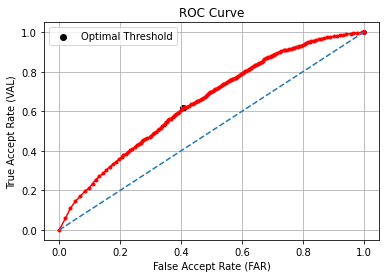

In [ ]:
best_threshold, tar, far, precision, accuracy  = evaluate(distances, psame, True)

In [ ]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 0.54
True Acceptance: 0.615
False Acceptance: 0.407
Precision: 0.602
Accuracy: 0.604


In [ ]:
vals = []
fars = []
frrs = []
trrs = []
precisions = []
gmeans = []
f1_scores = []
accuracies = []
youdens = []
x = np.arange(0, 4, 0.01)
for threshold in tqdm(x):
    val, far, precision, accuracy = calculate_metrics(threshold, distances, psame)
    youden = val - far
    gmean = np.sqrt(val* (1-far))
    youden = val - far
    f1_score = 2 * (precision * val) / (precision + val + 1e-16)

    vals.append(val)
    fars.append(far)
    precisions.append(precision)
    accuracies.append(accuracy)
    youdens.append(youden)
    gmeans.append(gmean)
    f1_scores.append(f1_score)


vals = np.asarray(vals)
fars = np.asarray(fars)
frrs = np.asarray(frrs)
trrs = np.asarray(trrs)
precisions = np.asarray(precisions)
gmeans = np.asarray(gmeans)
f1_scores = np.asarray(f1_scores)
youdens = np.asarray(youdens)

In [ ]:
p = np.argmax(precisions)
a = np.argmax(accuracies)
y = np.argmax(youdens)
f = np.argmax(f1_scores)
g = np.argmax(gmeans)

In [ ]:
precisions[p], accuracies[a], youdens[y], f1_scores[f], gmeans[g], x[y]

(0.7494305239179955,
 0.6043333333333333,
 0.2086666666666666,
 0.687753036437247,
 0.6042332147257197,
 0.54)

In [ ]:
np.argmin(abs((1-vals) - fars))

52

In [ ]:
x[52]

0.52

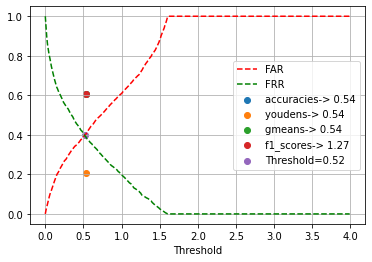

In [ ]:
plt.figure()
plt.plot(x, fars, 'r--', label='FAR')
plt.plot(x, 1-vals, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.scatter(x[a], accuracies[a], label=f'accuracies-> {x[a]}')
plt.scatter(x[y], youdens[y], label=f'youdens-> {x[y]}')
plt.scatter(x[y], gmeans[y], label=f'gmeans-> {x[g]}')
plt.scatter(x[y], f1_scores[y], label=f'f1_scores-> {x[f]}')
plt.scatter(0.52, fars[52],label="Threshold=0.52")
plt.legend()
plt.grid()
plt.show()

## Plotting False Accepts

In [ ]:
test_images = LFWDataset(path_list, issame_list, test_transform)
test_images

In [ ]:
preds = distances < 0.78
false_accepts = np.logical_and(preds, np.logical_not(psame))
false_accepts.shape

(6000,)

In [ ]:
false_accept_idxs =  (false_accepts == 1).nonzero()
len(false_accept_idxs)

1

In [ ]:
false_accept_idxs = false_accept_idxs[0]

In [ ]:
false_accept_idxs

array([ 301,  304,  305, ..., 5990, 5991, 5995])

741


<Figure size 432x288 with 0 Axes>

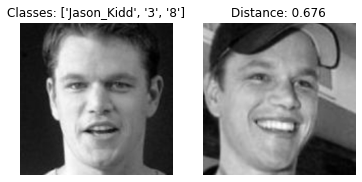

403


<Figure size 432x288 with 0 Axes>

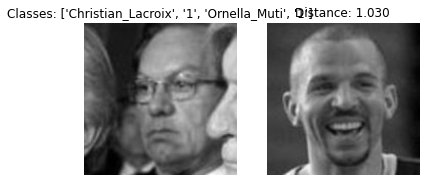

33


<Figure size 432x288 with 0 Axes>

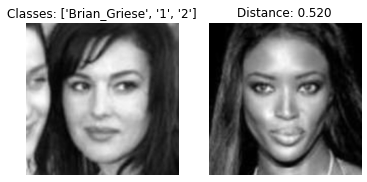

619


<Figure size 432x288 with 0 Axes>

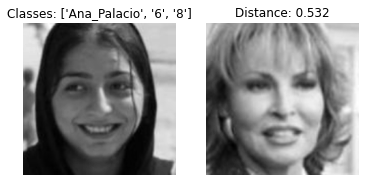

797


<Figure size 432x288 with 0 Axes>

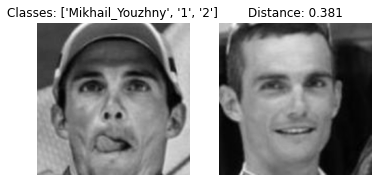

1160


<Figure size 432x288 with 0 Axes>

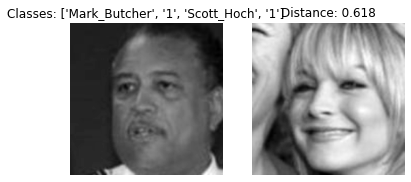

449


<Figure size 432x288 with 0 Axes>

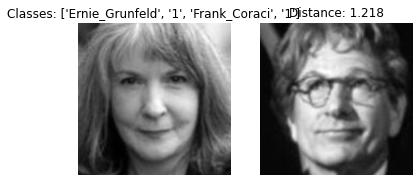

533


<Figure size 432x288 with 0 Axes>

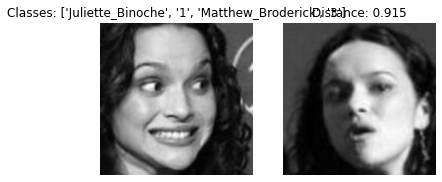

382


<Figure size 432x288 with 0 Axes>

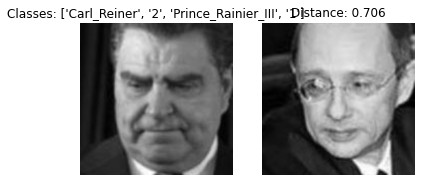

908


<Figure size 432x288 with 0 Axes>

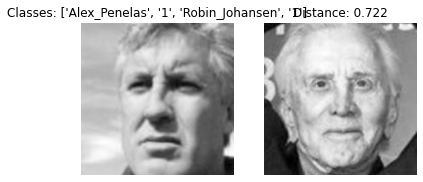

388


<Figure size 432x288 with 0 Axes>

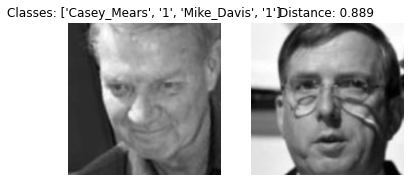

1132


<Figure size 432x288 with 0 Axes>

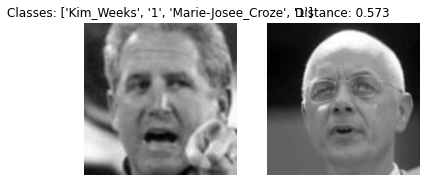

398


<Figure size 432x288 with 0 Axes>

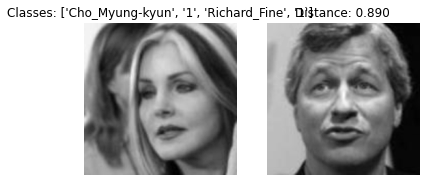

183


<Figure size 432x288 with 0 Axes>

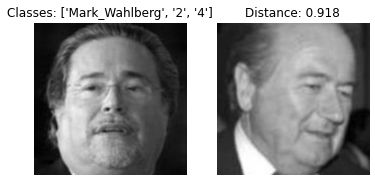

801


<Figure size 432x288 with 0 Axes>

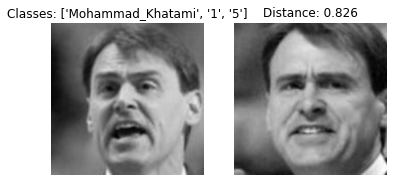

690


<Figure size 432x288 with 0 Axes>

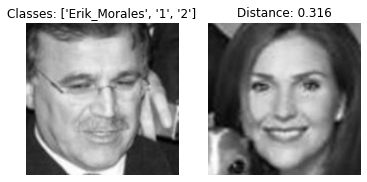

319


<Figure size 432x288 with 0 Axes>

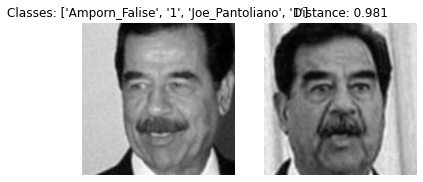

585


<Figure size 432x288 with 0 Axes>

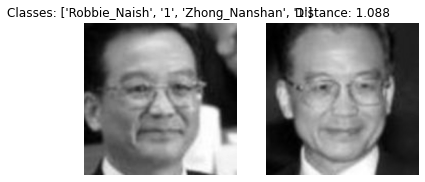

66


<Figure size 432x288 with 0 Axes>

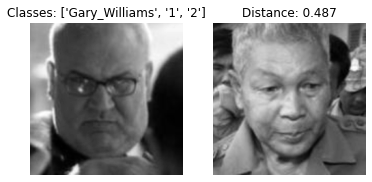

449


<Figure size 432x288 with 0 Axes>

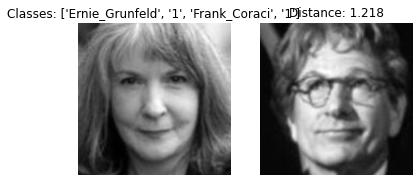

930


<Figure size 432x288 with 0 Axes>

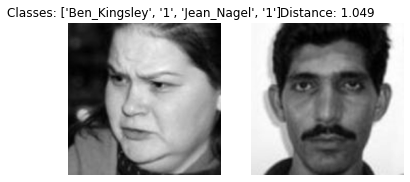

270


<Figure size 432x288 with 0 Axes>

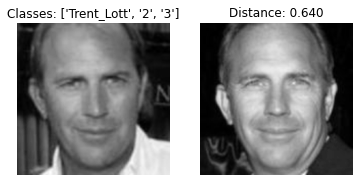

292


<Figure size 432x288 with 0 Axes>

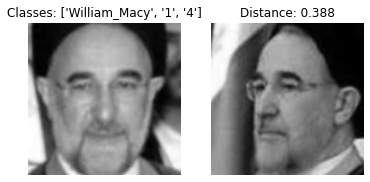

793


<Figure size 432x288 with 0 Axes>

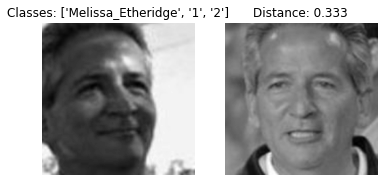

642


<Figure size 432x288 with 0 Axes>

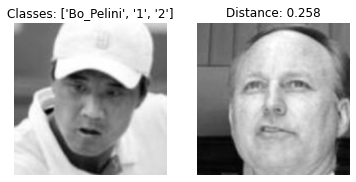

1182


<Figure size 432x288 with 0 Axes>

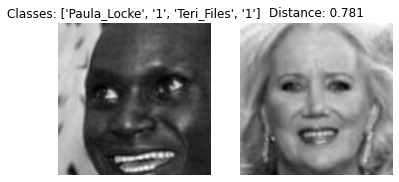

654


<Figure size 432x288 with 0 Axes>

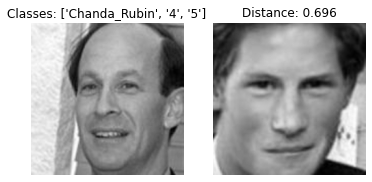

76


<Figure size 432x288 with 0 Axes>

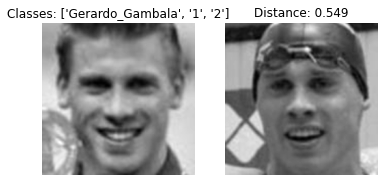

1010


<Figure size 432x288 with 0 Axes>

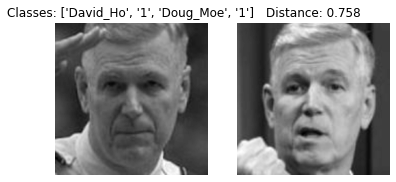

791


<Figure size 432x288 with 0 Axes>

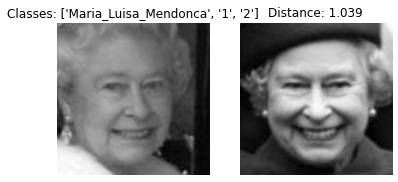

In [ ]:
for idx in np.random.randint(0,1187, size=30):
    print(idx)
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)

    idx1= false_accept_idxs[idx]
    idx2 = idx1+1

    i1.imshow(test_images[idx1].squeeze(), cmap='gray')
    i2.imshow(test_images[idx2].squeeze(), cmap='gray')
    i1.title.set_text(f'Classes: {pairs[idx]}')
    i2.title.set_text(f'Distance: {distances[idx]:.3f}')
    i1.axis('off')
    i2.axis('off')

    plt.show()